In [1]:
import numpy as np
from fireworks.ic import ic_two_body
import matplotlib.pyplot as plt
from fireworks.nbodylib.integrators import integrator_euler, integrator_leapfrog, integrator_rungekutta, integrator_tsunami
from fireworks.nbodylib.dynamics import acceleration_direct_vectorized #, acceleration_direct, acceleration_pyfalcon, acceleration_jerk_direct
from fireworks.particles import Particles
from typing import Optional, Tuple, Callable, Union
from numpy.random import random, seed
from fireworks.particles import Particles

#from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

Let's put in the particles (rebember that the units are Nbody units).

In [2]:
tevolve     = 65
position    = np.array([[0.,0.,0.],[0.5, 0.866,0],[1,0,0]])
velocity    = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
mass        = np.array([3.,4.,5.])
P           = Particles(position,velocity,mass)
print(P.pos )                                                                  # particles'positions
print(P.vel )                                                                  # particles'velocities
print(P.mass)                                                                  # particles'masses
print(P.ID  )                                                                  # particles'unique IDs


[[0.    0.    0.   ]
 [0.5   0.866 0.   ]
 [1.    0.    0.   ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[3. 4. 5.]
[0 1 2]


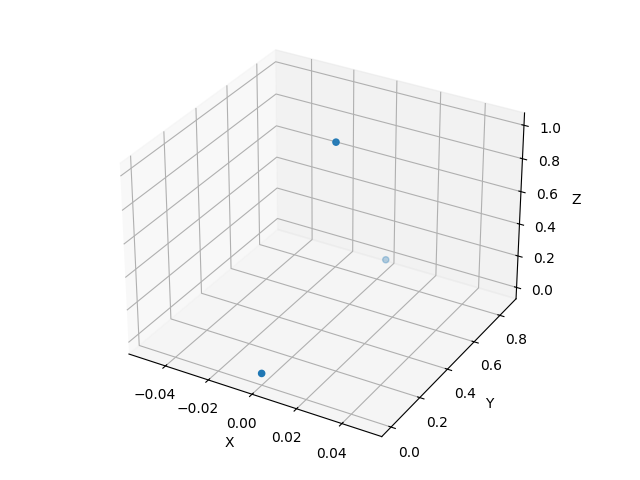

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P.pos[0,:], P.pos[1,:], P.pos[2,:] )
#ax.scatter(P.pos[0,:], label=f'$M_1$', color='C0')
#ax.scatter(P.pos[1,:], label=f'$M_2$', color='C1')
#ax.scatter(P.pos[2,:], label=f'$M_3$', color='C2')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()

### TSUNAM EVOLUTION

Now we can evolve the system using the TSUNAMI integrator. 

As initial condition we put $t_{start}$ = 0$ and $t_{simulation} = t_{evolve} = 65$ defined previously. To perform the integration we devide this interval in $n = METTERE QUANTO$ parts linearly spaced.

In [4]:
def integration_with_tsunami_3body(part, tsimulation):
    tstart=0
    tintermediate = np.linspace(tstart, tsimulation, 2)
    tcurrent=0
    pos1_tsu = []
    pos2_tsu = []
    pos3_tsu = []
    #Epot_tsu = []
    #Ekin_tsu = []
    #Etot_tsu = []
    t_tsunami = []

    for t in tintermediate:
        tstep=t-tcurrent
        if tstep <=0: continue 
        part_tsunami, efftime,_,_,_=integrator_tsunami(part, tstep)

        #I append the positions
        pos1_tsu.append(part_tsunami.pos[0].copy())
        pos2_tsu.append(part_tsunami.pos[1].copy())
        pos3_tsu.append(part_tsunami.pos[2].copy())

        #I append the energies
        #Etot_n, Ekin_n, Epot_n =  part_tsunami.Etot()
        #Etot_tsu.append(Etot_n)
        #Ekin_tsu.append(Ekin_n)
        #Epot_tsu.append(Epot_n)

        #I append the times
        t_tsunami.append(tcurrent)

        tcurrent=tcurrent+efftime

    #I transform everything in numpy arrays
    pos1_tsu    = np.array(pos1_tsu)
    pos2_tsu    = np.array(pos2_tsu)
    pos3_tsu    = np.array(pos3_tsu)
    #Epot_tsu    = np.array(Epot_tsu)
    #Ekin_tsu    = np.array(Ekin_tsu)
    #Etot_tsu    = np.array(Etot_tsu)
    t_tsunami   = np.array(t_tsunami)


    return pos1_tsu, pos2_tsu, pos3_tsu, t_tsunami #, Epot_tsu, Ekin_tsu, Etot_tsu

In [5]:
P_tsu = P.copy()

In [ ]:
pos1_tsu_1, pos2_tsu_1, pos3_tsu, t_tsunami = integration_with_tsunami_3body(P, tevolve)

### OTHER INTEGRATORS

Let's begin with the `euler integrator` and let's use the `acceleration_pyfalcon`. These are the fastest among the other analogous competitors.

In [ ]:
def integration_euler(part, h, tsimulation, t, N, softening):
    path_1 = []
    path_2 = []
    path_3 = []
    #Etot_euler = []
    #Ekin_euler = []
    #Epot_euler = []

    while t < tsimulation:
        for j in range(1,N):
            result = integrator_euler(part, h, acceleration_pyfalcon, softening: softening)
            updated_part, tstep, updated_acc, _, _ = result
            path_1.append(updated_part.pos[0])
            path_2.append(updated_part.pos[1])
            path_3.append(updated_part.pos[2])
            #Etot_n, Ekin_n, Epot_n = updated_part.Etot()
            #Etot_euler.append(Etot_n)
            #Ekin_euler.append(Ekin_n)
            #Epot_euler.append(Epot_n)

        t += h

    path_1 = np.array(path_1)
    path_2 = np.array(path_2)
    path_3 = np.array(path_3)
    #Etot_euler = np.array(Etot_euler)
    #Ekin_euler = np.array(Ekin_euler)
    #Etot_euler = np.array(Epot_euler)

    return path_1, path_2, path_3, #, Etot_euler, Ekin_euler, Epot_euler

In [ ]:
P_euler = P.copy()
h = 5
N = 3
t = 0
softening = 10

part_euler, tstep_euler, _, _, _ = integrator_euler(P_euler, h, tevolve, t, N, softening)